# Comparative Visualization of Taxonomic Classifiers

Creates a basic visualization of the taxonomic assignments created by several taxonomic classification and alignment tools on the same metaribo-seq dataset.
I aligned data using the following classifiers/databases (specific parameters can be found in the readme):
- Centrifuger w/ GTDB r226, Refseq human, virus, fungi, contaminants (cf_gtdb)
- Centrifuger w/ NCBI nt (cf_nt)
- Centrifuger with Refseq HBAV & SARS-COV2 variants (cf_rs)
- Kraken2 with Refseq HBAV (k2_rs)
- DIAMOND with NCBI nr (dmd_nr)
- DIAMOND with Uniref100 (dmd_ur)

### Workflow:
- Preliminary classification statistics (total species hits per classifier, total species with > 50 hits per classifier)
- Species and genus-level composition per classifier
- Similarity between classifiers, in terms of estimated ribo-seq composition at genus level
***

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src import taxo_utils

## Data preprocessing

In [2]:
#summary tsvs from classification tools
summaries = [r'raw_data\classification_results\cf_gtdb_summary.tsv',
             r'raw_data\classification_results\cf_nt_summary.tsv',
             r'raw_data\classification_results\cf_rs_summary.tsv',
             r'raw_data\classification_results\k2_rs_summary.tsv',
             r'raw_data\classification_results\dmd_nr_summary.tsv',
             r'raw_data\classification_results\dmd_ur_summary.tsv',
             ]

#classifier & database names for legends
ind_to_df_mapping = {
    0: 'cf_gtdb',
    1: 'cf_nt',
    2: 'cf_rs',
    3: 'k2_rs',
    4: 'dmd_nr',
    5: 'dmd_ur',
}

In [3]:
df_list = []
for summary in summaries:
    df = pd.read_csv(summary, sep='\t')
    df_list.append(df)

In [4]:
#rename columns for consistency
df_list[0].rename(columns={'totalNumMatches': 'count'}, inplace = True)
df_list[1].rename(columns={'totalNumMatches': 'count'}, inplace = True)
df_list[2].rename(columns={'totalNumMatches': 'count'}, inplace = True)
df_list[3].rename(columns={'  # Direct': 'count'}, inplace = True)
df_list[3].rename(columns={'Scientific name               ': 'name'}, inplace=True)

In [5]:
for df in df_list:
    df['proportion'] = df['count'] / df['count'].sum()

In [6]:
for i in range(len(df_list)):
    df_list[i] = df_list[i][['name', 'proportion', 'count']]
    df_list[i].set_index('name', inplace=True)

In [7]:
# resolve major discrepancies in species naming between databases; 
# only S. kunmingensis/chloritidismutans is significantly affected

rename_map = {
    "Stutzerimonas kunmingensis": "Stutzerimonas chloritidismutans"
}

for df in df_list:
    for old, new in rename_map.items():
        if old in df.index:
            if new in df.index:
                df.at[new, "count"] += df.at[old, "count"]
                df.at[new, "proportion"] += df.at[old, "proportion"]
            else:
                df.loc[new] = df.loc[old]
            df.drop(old, inplace=True)

### Preliminary classification statistics

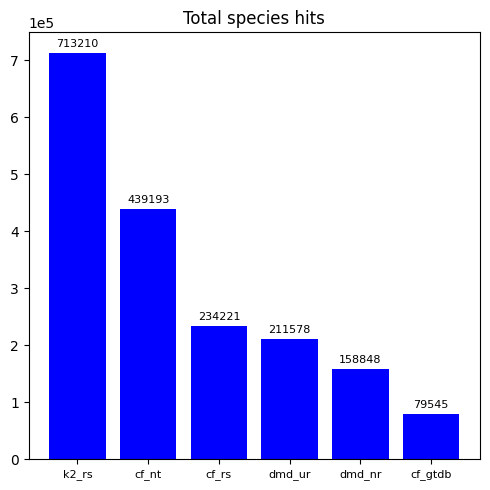

In [8]:
#calculate and plot total species hits per classifier
temp_c = sorted([(df['count'].sum(), ind_to_df_mapping[i]) for i, df in enumerate(df_list)], reverse=True)

total_counts, classifier_names = zip(*temp_c)

taxo_utils.barplot_hits(total_counts, classifier_names, out_path = r'figures\classifier_comp\total_hits.png')

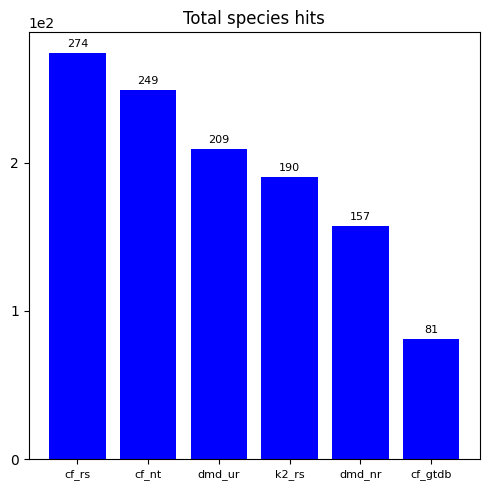

In [9]:
#calculate and plot # species with > 50 hits for each classifier
temp_c50 = sorted([(len(df[df['count'] > 50]['count']), ind_to_df_mapping[i]) for i, df in enumerate(df_list)], reverse=True)

counts_above_50, classifier_names = zip(*temp_c50)

taxo_utils.barplot_hits(counts_above_50, classifier_names, out_path = r'figures\classifier_comp\above_50.png')

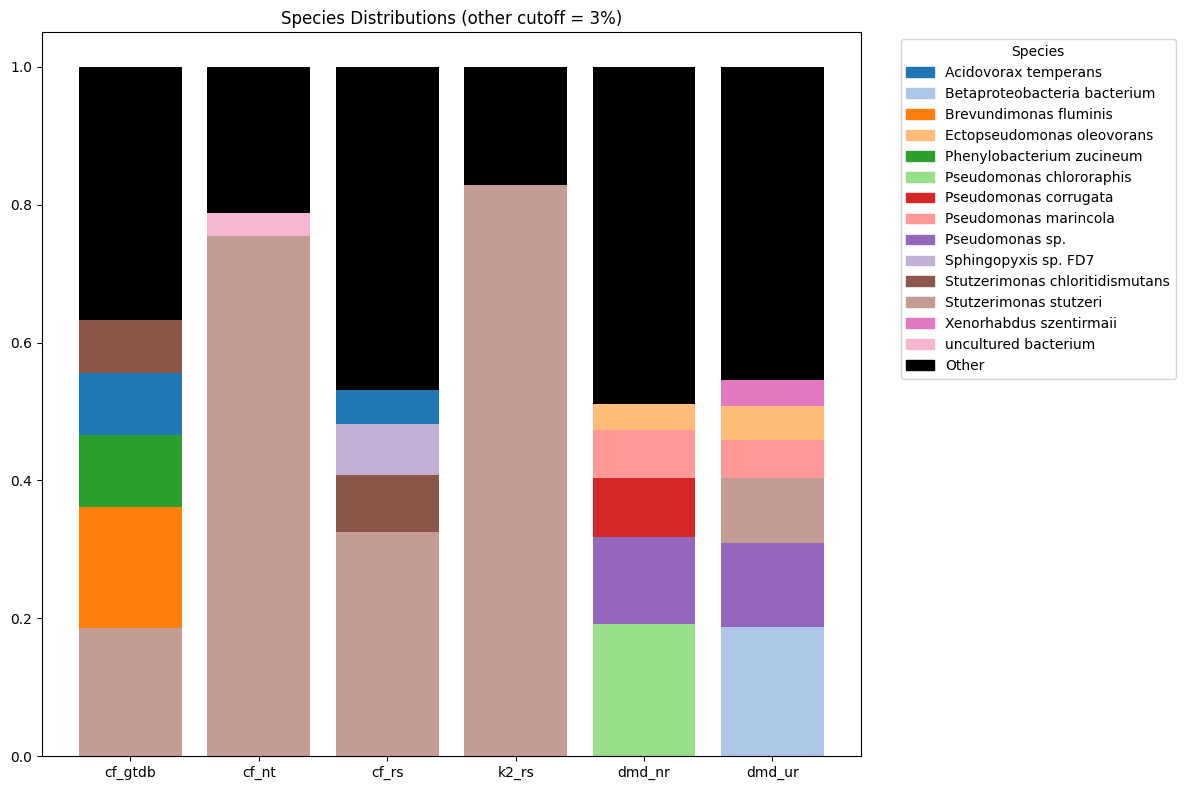

In [10]:
taxo_utils.plot_species_distributions(df_list, ind_to_df_mapping, cutoff = 0.03, 
                                    out_path =  r'figures\barplots\all_species_03.png')


In [11]:
df_list_genera = taxo_utils.extract_genus_from_species(df_list)

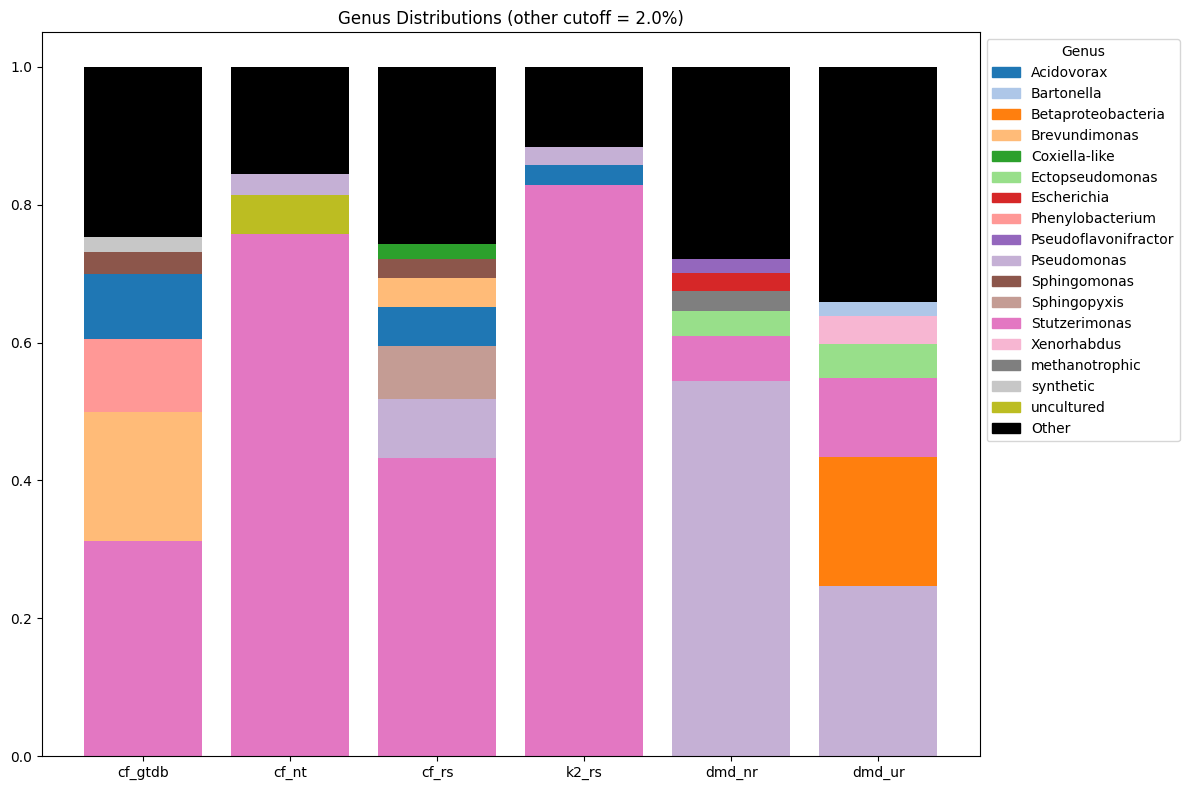

In [12]:
taxo_utils.plot_genus_distributions(df_list_genera, ind_to_df_mapping, cutoff = 0.02)


In [13]:
ind_to_count_mapping = {i: df_list[i]['count'].sum() for i in range(len(df_list))}

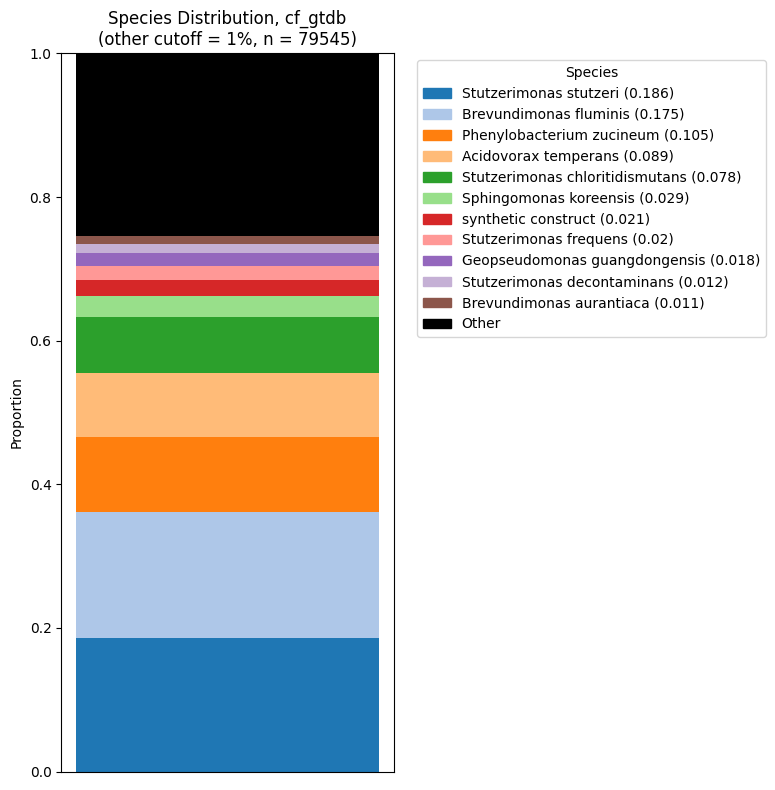

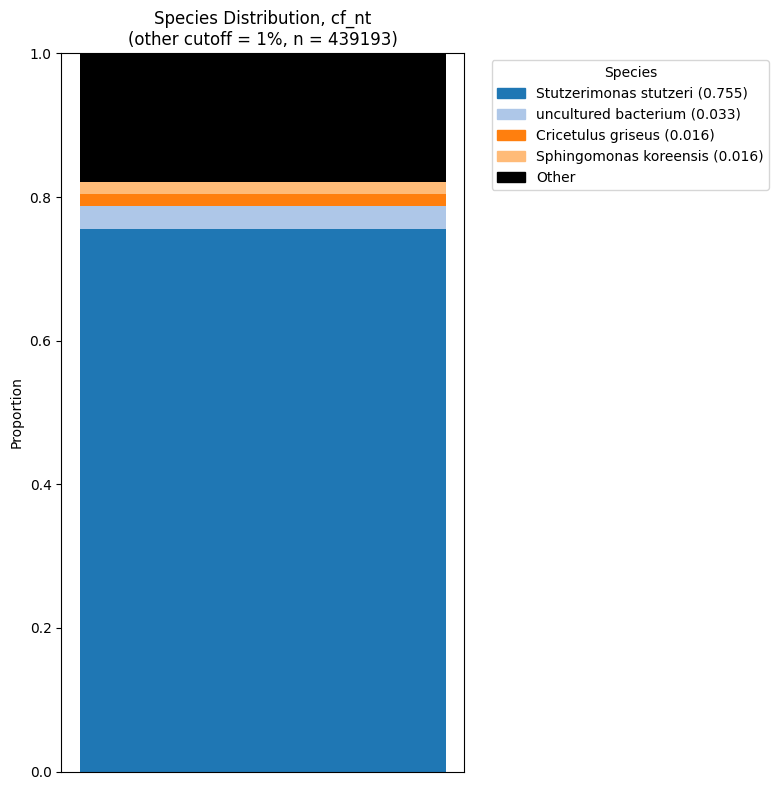

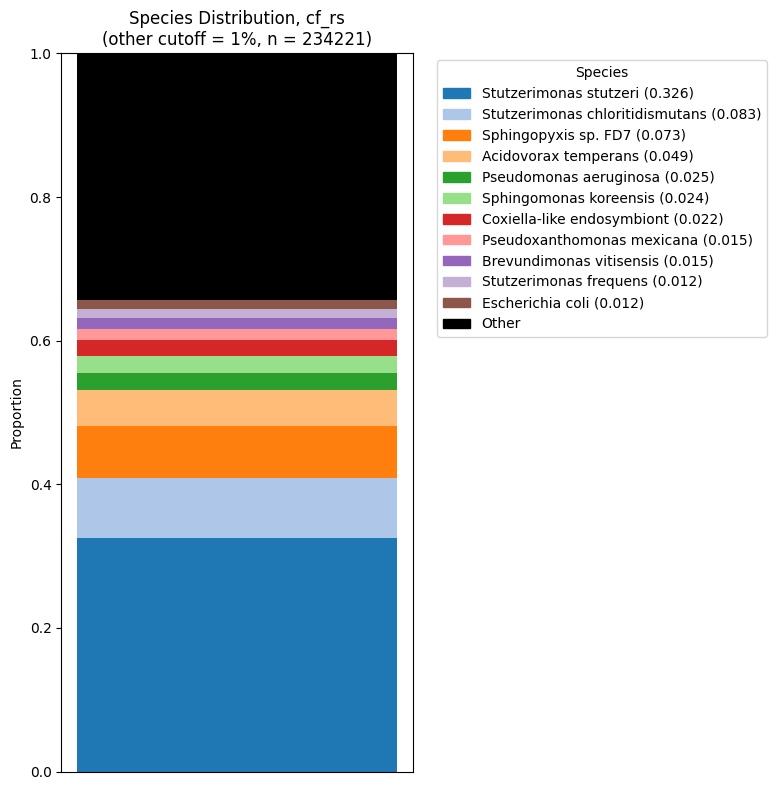

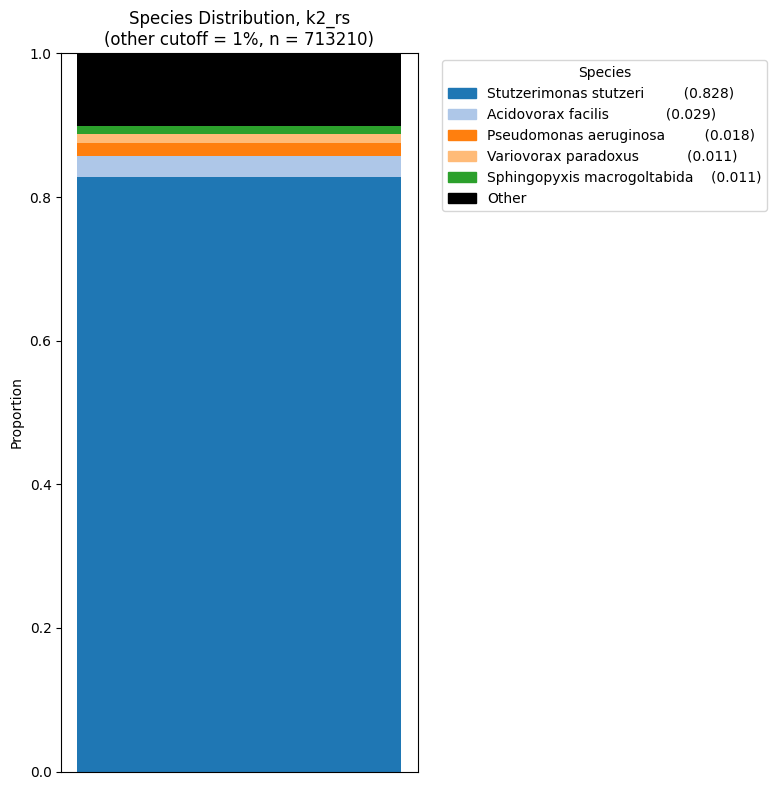

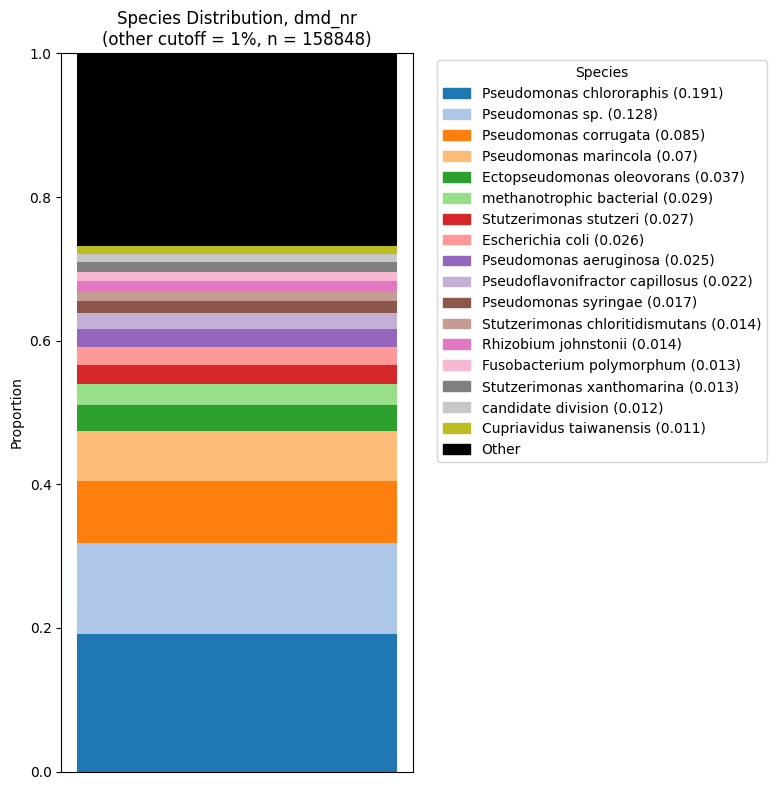

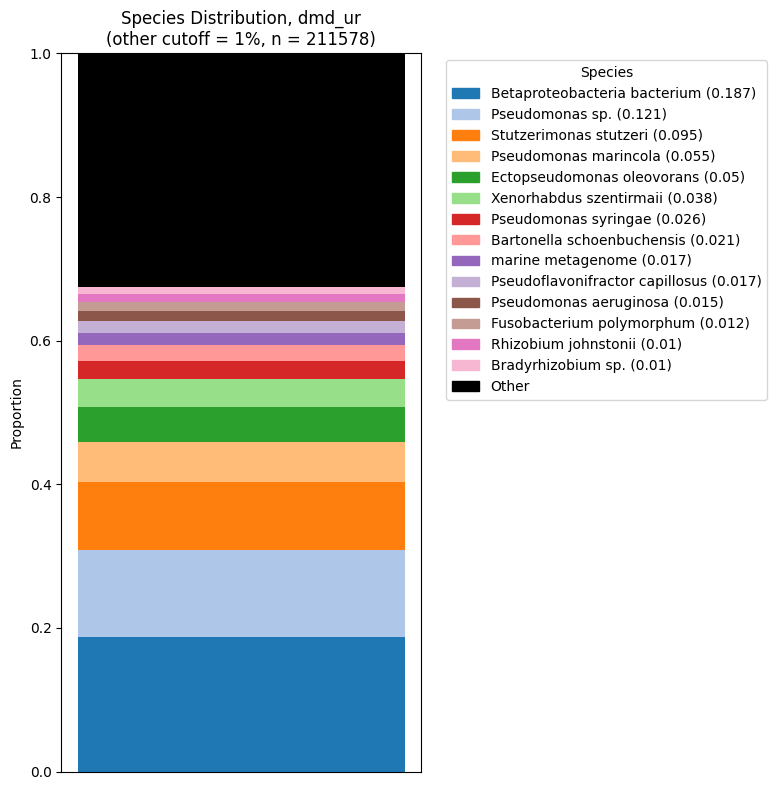

In [14]:
taxo_utils.plot_individual_distributions(df_list, ind_to_df_mapping, ind_to_count_mapping, cutoff=0.01)


### Preliminary classifier comparison

                  proportion  count
genus                              
Stutzerimonas       0.312037  24821
Brevundimonas       0.187529  14917
Phenylobacterium    0.106116   8441
Acidovorax          0.094337   7504
Sphingomonas        0.031630   2516
200
Aitchison Distance Matrix:
            cf_gtdb       cf_nt       cf_rs       k2_rs      dmd_nr  \
cf_gtdb    0.000000  203.693266  208.519669  213.349642  220.467992   
cf_nt    203.693266    0.000000  175.240328  181.262657  193.020579   
cf_rs    208.519669  175.240328    0.000000  184.683169  198.782821   
k2_rs    213.349642  181.262657  184.683169    0.000000  195.305883   
dmd_nr   220.467992  193.020579  198.782821  195.305883    0.000000   
dmd_ur   222.734186  194.329660  208.012830  201.999018  144.302146   

             dmd_ur  
cf_gtdb  222.734186  
cf_nt    194.329660  
cf_rs    208.012830  
k2_rs    201.999018  
dmd_nr   144.302146  
dmd_ur     0.000000  


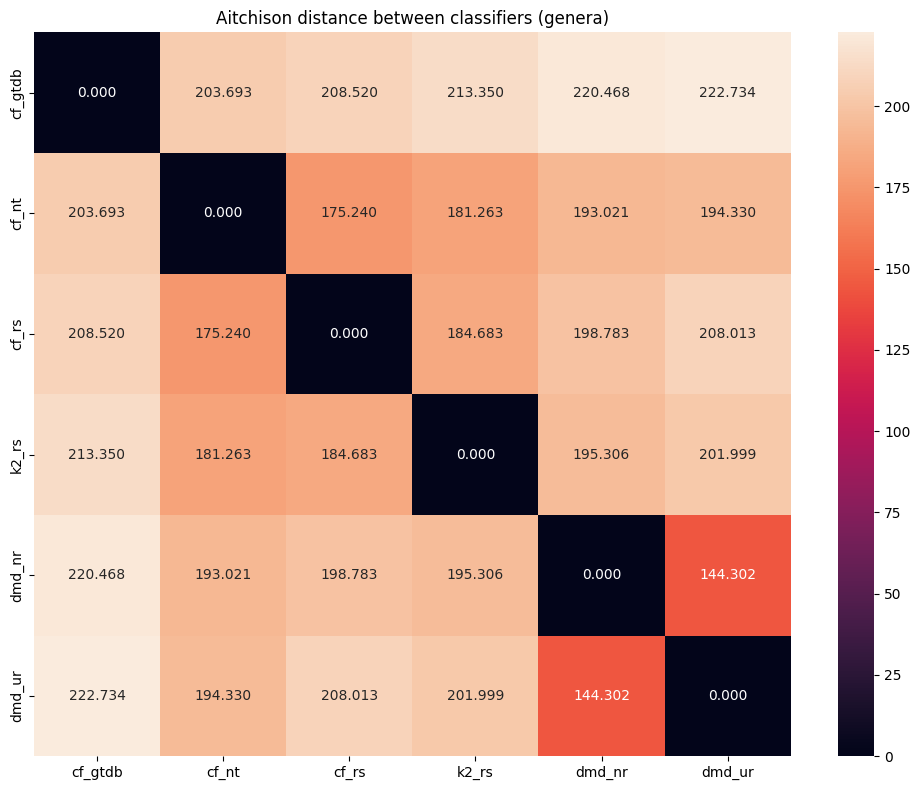

In [15]:
distance_matrix = taxo_utils.calculate_distance_matrix(df_list_genera, ind_to_df_mapping, distance_type='aitchison', top_n=200)

t_100_genera = [df.sort_values(by='proportion', ascending = False).iloc[0:200] for df in df_list_genera]
print(t_100_genera[0].head())
print(len(t_100_genera[0]['proportion']))

print('Aitchison Distance Matrix:')
print(distance_matrix)

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(
    distance_matrix,
    annot=True,
    fmt='.3f',
)

plt.title('Aitchison distance between classifiers (genera)')
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.savefig(r'figures\ait_dist.png')
plt.show()

BC Dissimilarity Matrix:
          cf_gtdb     cf_nt     cf_rs     k2_rs    dmd_nr    dmd_ur
cf_gtdb  0.000000  0.614552  0.489965  0.611508  0.877110  0.817080
cf_nt    0.614552  0.000000  0.434908  0.155389  0.837081  0.773414
cf_rs    0.489965  0.434908  0.000000  0.432151  0.754875  0.705315
k2_rs    0.611508  0.155389  0.432151  0.000000  0.857604  0.799312
dmd_nr   0.877110  0.837081  0.754875  0.857604  0.000000  0.431066
dmd_ur   0.817080  0.773414  0.705315  0.799312  0.431066  0.000000


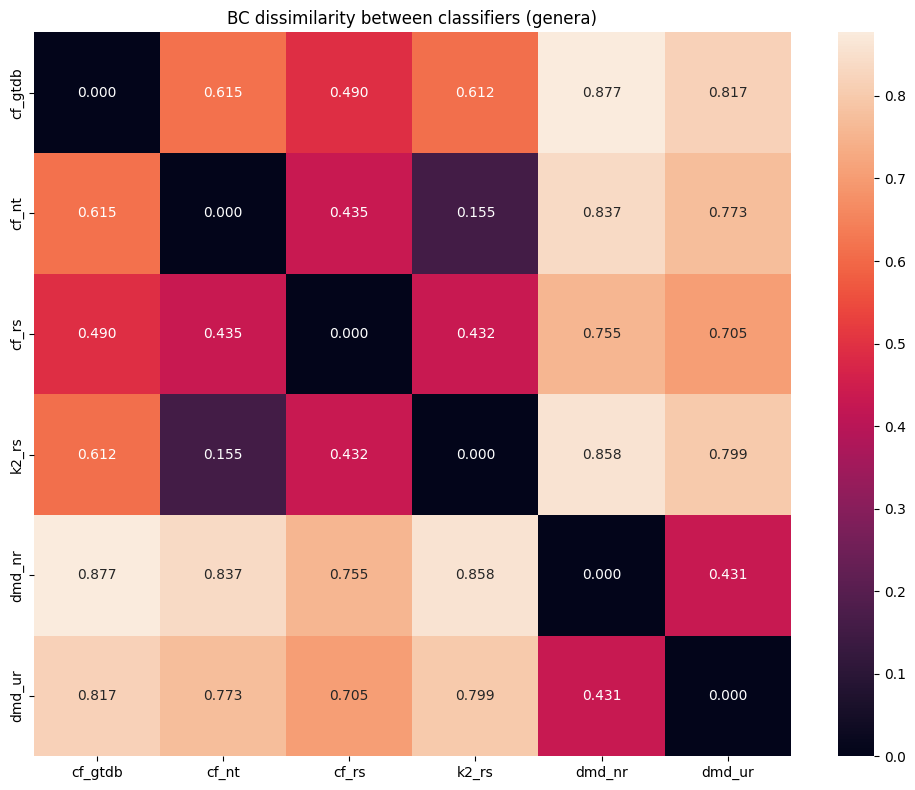

In [16]:
distance_matrix = taxo_utils.calculate_distance_matrix(df_list_genera, ind_to_df_mapping, distance_type='bray_curtis')

print('BC Dissimilarity Matrix:')
print(distance_matrix)

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(
    distance_matrix,
    annot=True,
    fmt='.3f',
    # cmap='mako_r'
)
plt.title('BC dissimilarity between classifiers (genera)')
plt.tight_layout()
plt.savefig(r'figures\bc_dist.png')
plt.show()